In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torch.optim as optim

In [3]:
import pickle
import numpy as np

def unpickle(file):
    with open(file, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
    return dict

In [4]:
def load_cifar10_data(data_dir):
    train_data = []
    train_labels = []

    # Load training batches
    for i in range(1, 6):
        batch = unpickle(f"{data_dir}/data_batch_{i}")
        train_data.append(batch[b'data'])
        train_labels += batch[b'labels']

    train_data = np.concatenate(train_data, axis=0)
    train_data = train_data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)  # Reshape to (N, H, W, C)
    train_labels = np.array(train_labels)

    # Load test batch
    test_batch = unpickle(f"{data_dir}/test_batch")
    test_data = test_batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    test_labels = np.array(test_batch[b'labels'])

    return (train_data, train_labels), (test_data, test_labels)


In [5]:


class CIFAR10Dataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # image = self.data[idx]
        image = Image.fromarray(self.data[idx])
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Load data
(data_dir) = '/kaggle/input/cifar10-python/cifar-10-batches-py'
(train_data, train_labels), (test_data, test_labels) = load_cifar10_data(data_dir)


In [6]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),#usng this for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create PyTorch datasets and loaders
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=test_transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
device

'cuda'

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(64,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(373248,512),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    def forward(self,x):
        x = self.conv_layer(x)
        return x

In [14]:
model = CNN().to(device)

In [16]:
optimizer = optim.SGD(model.parameters(),lr=1e-02)
loss_fn = nn.CrossEntropyLoss()
epochs = 10

In [17]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    model.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = model(x)
        loss = loss_fn(pred,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')

    model.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = model(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

KeyboardInterrupt: 

In [ ]:
(torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum()

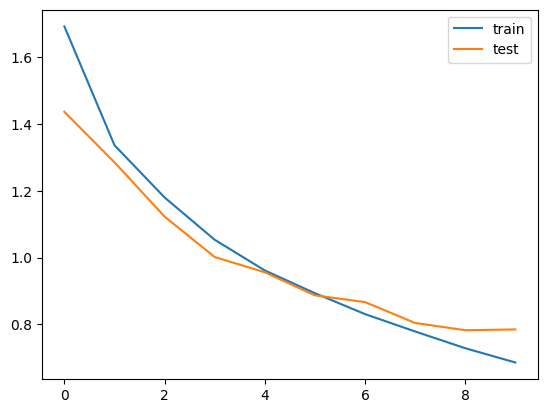

In [32]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()


Alexnet

In [104]:
from torchvision.models import alexnet

In [105]:
alex = alexnet(pretrained=True)

In [106]:
alex.classifier[6] = nn.Linear(4096,10) #Changing this as the out_features for alexnet is 1000

In [107]:
alex = alex.to(device)

In [108]:
#hyperparameters
alex_optim = optim.SGD(alex.parameters(),lr = 1e-03)
epochs = 5

In [113]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    model.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = alex(x)
        loss = loss_fn(pred,y)
        loss.backward()
        alex_optim.step()
        alex_optim.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')

    model.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = alex(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

Epoch: 0 | Train loss: 0.812550063201501
Test_loss 0.6125154553796537 | Accuracy 0.7858
Epoch: 1 | Train loss: 0.5381268871112733
Test_loss 0.5080711938226565 | Accuracy 0.8232
Epoch: 2 | Train loss: 0.4634279708830272
Test_loss 0.46217511846615483 | Accuracy 0.838
Epoch: 3 | Train loss: 0.4131842792005548
Test_loss 0.4256678289308335 | Accuracy 0.8505
Epoch: 4 | Train loss: 0.3814634545989244
Test_loss 0.41562998468597856 | Accuracy 0.8567


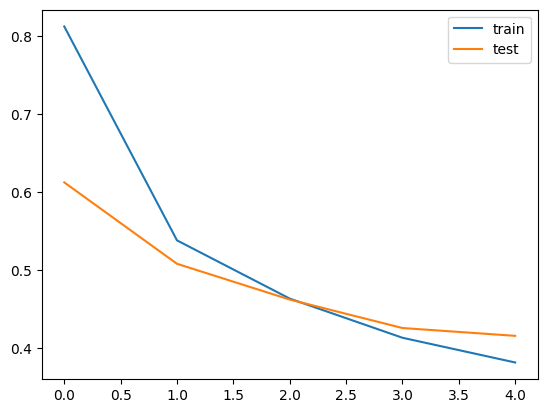

In [114]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()


RESNET 

In [8]:
# Define transformations
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
    transforms.Resize((224,224)),#usng this for AlexNet
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create PyTorch datasets and loaders
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=test_transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
from torchvision import models

In [10]:
resnetmodel = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [11]:
for param in resnetmodel.parameters():
    param.requires_grad = False

In [12]:
resnetmodel.fc.in_features

512

In [14]:
#modify the FCN
input_tolinear = resnetmodel.fc.in_features
resnetmodel.fc = nn.Linear(in_features=input_tolinear,out_features = 10)
resnetmodel = resnetmodel.to(device)

In [21]:
# from torch.optim import lr_scheduler

In [ ]:
#hyperparam
# resnet_optim = optim.SGD(resnetmodel.parameters(),lr=1e-03,momentum=0.9,weight_decay=0.0001)
resnet_optim = optim.Adam(resnetmodel.parameters(),lr=1e-03,weight_decay=0.0001)

# scheduler = lr_scheduler.StepLR(resnet_optim, step_size=5, gamma=0.1)
epochs = 50
loss_fn = nn.CrossEntropyLoss()

In [16]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    resnetmodel.train()
    train_loss =0.0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        pred = resnetmodel(x)
        loss = loss_fn(pred,y)
        loss.backward()
        resnet_optim.step()
        resnet_optim.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')
    # scheduler.step()

    resnetmodel.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = resnetmodel(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

Epoch: 0 | Train loss: 0.7992727214605169
Test_loss 0.6289210313330063 | Accuracy 0.7842
Epoch: 1 | Train loss: 0.6373894237034304
Test_loss 0.6185738284366961 | Accuracy 0.7877
Epoch: 2 | Train loss: 0.6142570945938962
Test_loss 0.5784567578817709 | Accuracy 0.8008
Epoch: 3 | Train loss: 0.6046276461864539
Test_loss 0.5698405827005831 | Accuracy 0.8049
Epoch: 4 | Train loss: 0.5999237800437673
Test_loss 0.5747805798586946 | Accuracy 0.8083
Epoch: 5 | Train loss: 0.5968948799642476
Test_loss 0.586471114819423 | Accuracy 0.8006
Epoch: 6 | Train loss: 0.5886917396455107
Test_loss 0.5919100808830687 | Accuracy 0.7981
Epoch: 7 | Train loss: 0.5912002619410736
Test_loss 0.5800843255969282 | Accuracy 0.8029
Epoch: 8 | Train loss: 0.5893803477592371
Test_loss 0.5913121952606847 | Accuracy 0.8007
Epoch: 9 | Train loss: 0.5848044023365832
Test_loss 0.5712800994753456 | Accuracy 0.8069
Epoch: 10 | Train loss: 0.582809836463675
Test_loss 0.5807045695785517 | Accuracy 0.8031
Epoch: 11 | Train loss

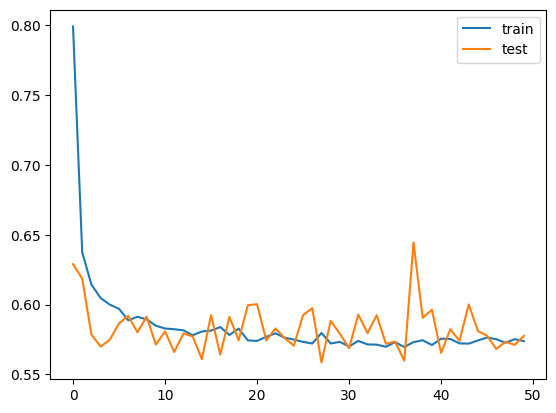

In [17]:
plt.plot(train_losses,label='train')
plt.plot(test_losses,label='test')
plt.legend()

ResNEXT

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
# Create PyTorch datasets and loaders
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=test_transform)
test_dataset = CIFAR10Dataset(test_data, test_labels, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [30]:
resnextmodel = models.resnext50_32x4d(pretrained=True)
resnextmodel = resnextmodel.to(device)

In [38]:
device = next(resnextmodel.parameters()).device
print(f"The model is on: {device}")

The model is on: cuda:0


In [39]:
# Modify the final layer to match the number of classes
num_ftrs = resnextmodel.fc.in_features
resnextmodel.fc = nn.Linear(num_ftrs, 10)

In [32]:
import torch.optim as optim

resnext_optim = optim.Adam(resnextmodel.parameters(), lr=1e-03, weight_decay=0.0001)
loss_fn = nn.CrossEntropyLoss()
epochs = 10
from torch.optim import lr_scheduler

scheduler = lr_scheduler.StepLR(resnext_optim, step_size=5, gamma=0.1)

In [40]:
train_losses,test_losses = [],[]
for epoch in range(epochs):
    resnextmodel.train()
    train_loss =0
    for batch,(x,y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)
        print(x)
        pred = resnextmodel(x)
        loss = loss_fn(pred,y)
        loss.backward()
        resnext_optim.step()
        resnext_optim.zero_grad()

        #Metrics 
        train_loss += loss.item()
        
    avg_loss = train_loss/len(train_loader)
    train_losses.append(avg_loss)
    print(f'Epoch: {epoch} | Train loss: {avg_loss}')
    scheduler.step()

    resnextmodel.eval()
    with torch.no_grad():
        test_loss,correct=0,0
        total_samples = 0
        for batch,(x,y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            pred = resnextmodel(x)
            loss = loss_fn(pred,y)
            total_samples += y.size(0)
            test_loss += loss.item()
            correct += ((torch.argmax(torch.softmax(pred,dim=1),dim=1)==y).sum().item())
        avg_test_loss = test_loss/len(test_loader)
        avg_correct = correct/total_samples
        test_losses.append(avg_test_loss)
        print(f'Test_loss {avg_test_loss} | Accuracy {avg_correct}')

tensor([[[[-0.2471, -0.2471, -0.2471,  ..., -0.4745, -0.4745, -0.4745],
          [-0.2471, -0.2471, -0.2471,  ..., -0.4745, -0.4745, -0.4745],
          [-0.2471, -0.2471, -0.2471,  ..., -0.4745, -0.4745, -0.4745],
          ...,
          [-0.2941, -0.2941, -0.2941,  ..., -0.5137, -0.5137, -0.5137],
          [-0.2941, -0.2941, -0.2941,  ..., -0.5137, -0.5137, -0.5137],
          [-0.2941, -0.2941, -0.2941,  ..., -0.5137, -0.5137, -0.5137]],

         [[-0.2078, -0.2078, -0.2078,  ..., -0.4196, -0.4196, -0.4196],
          [-0.2078, -0.2078, -0.2078,  ..., -0.4196, -0.4196, -0.4196],
          [-0.2078, -0.2078, -0.2078,  ..., -0.4196, -0.4196, -0.4196],
          ...,
          [-0.2000, -0.2000, -0.2000,  ..., -0.4275, -0.4275, -0.4275],
          [-0.2000, -0.2000, -0.2000,  ..., -0.4275, -0.4275, -0.4275],
          [-0.2000, -0.2000, -0.2000,  ..., -0.4275, -0.4275, -0.4275]],

         [[-0.5843, -0.5843, -0.5843,  ..., -0.6078, -0.6078, -0.6078],
          [-0.5843, -0.5843, -

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)